# Part 1

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchsummary import summary
import torch_directml

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [4]:
classes = training_data.classes
print(classes)

num_training_samples = len(training_data)
print(f"Number of samples in the training data: {num_training_samples}")

num_test_samples = len(test_data)
print(f"Number of samples in the test data: {num_test_samples}")

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Number of samples in the training data: 60000
Number of samples in the test data: 10000


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


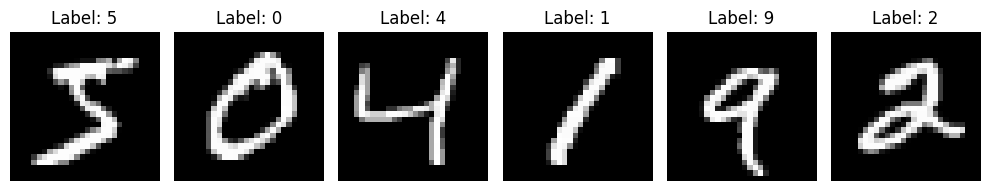

In [5]:
batch_size = 64 # we will talk about it later

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

    fig, axes = plt.subplots(1, 6, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(6):
        img = X[i].squeeze().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Label: {y[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    break

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
     else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
summary(model, input_size=(1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # Let's use stocastic gradient descent (We will talk about it in the coming weeks)

In [10]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss, correct = 0, 0  # Track the total loss for the epoch

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()  # Accumulate loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Calculate accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = total_loss / len(dataloader)  # Calculate average loss for the epoch
    avg_accuracy = correct / size

    train_losses.append(avg_loss)  # Store the average loss for the epoch
    train_accuracies.append(avg_accuracy) # Store the average accuracy for the epoch

    print(f"Train loss: {avg_loss:>7f}, Accuracy: {(100*avg_accuracy):>0.1f}%")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)  # Store the test loss for the epoch
    test_accuracies.append(correct)

    print(f"Test Error: \n Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")


In [12]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.307924  [   64/60000]
loss: 2.296140  [ 6464/60000]
loss: 2.284869  [12864/60000]
loss: 2.288924  [19264/60000]
loss: 2.285687  [25664/60000]
loss: 2.276774  [32064/60000]
loss: 2.267572  [38464/60000]
loss: 2.266652  [44864/60000]
loss: 2.254244  [51264/60000]
loss: 2.249759  [57664/60000]
Train loss: 2.276657, Accuracy: 33.0%
Test Error: 
 Avg loss: 2.249356, Accuracy: 51.2% 

Epoch 2
-------------------------------
loss: 2.255201  [   64/60000]
loss: 2.239902  [ 6464/60000]
loss: 2.241501  [12864/60000]
loss: 2.220222  [19264/60000]
loss: 2.230901  [25664/60000]
loss: 2.219089  [32064/60000]
loss: 2.200880  [38464/60000]
loss: 2.217400  [44864/60000]
loss: 2.185256  [51264/60000]
loss: 2.177558  [57664/60000]
Train loss: 2.217999, Accuracy: 57.6%
Test Error: 
 Avg loss: 2.176654, Accuracy: 62.8% 

Epoch 3
-------------------------------
loss: 2.183317  [   64/60000]
loss: 2.159122  [ 6464/60000]
loss: 2.174584  [12864/60000]
loss: 2.12

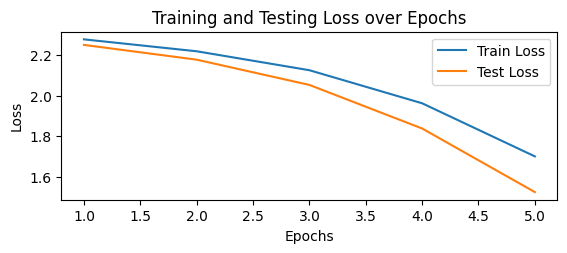

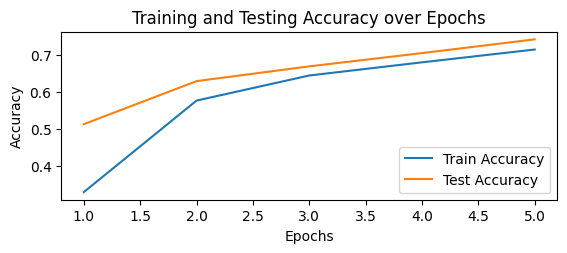

In [13]:
plt.subplot(2,1,1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.show()

Predicted: "7 - seven", Actual: "7 - seven"


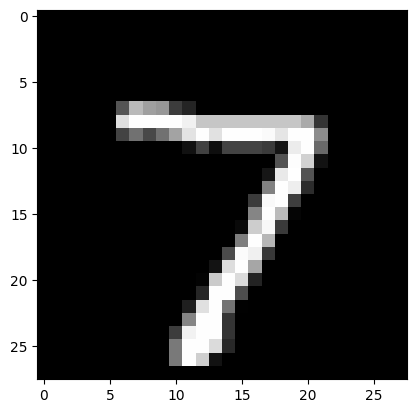

In [14]:
model.eval()
idx = 0
x, y = test_data[idx][0], test_data[idx][1]
plt.imshow(x.permute(1,2,0), cmap = 'gray')
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Part 2

In [15]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [16]:
classes = training_data.classes
print(classes)

num_training_samples = len(training_data)
print(f"Number of samples in the training data: {num_training_samples}")

num_test_samples = len(test_data)
print(f"Number of samples in the test data: {num_test_samples}")


['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Number of samples in the training data: 60000
Number of samples in the test data: 10000


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


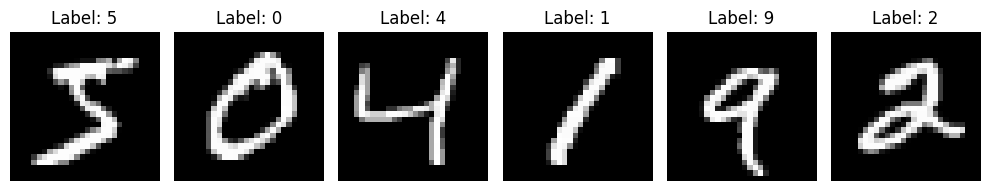

In [17]:
batch_size = 64 # we will talk about it later

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, pin_memory=True)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

    fig, axes = plt.subplots(1, 6, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(6):
        img = X[i].squeeze().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Label: {y[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    break

In [18]:
# Get cpu, gpu or mps device for training.
device = torch_directml.device(torch_directml.default_device()) 

# Check the number of available DirectML devices
num_devices = torch_directml.device_count()
print(f"Number of DirectML devices: {num_devices}")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1,)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1,)

        # Pooling layer
        self.pool = nn.MaxPool2d(2,2)

        # Linear layer
        self.linear1 = nn.Linear(256,120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        
        # Activation layer
        self.relu = nn.ReLU(inplace=True)

        # Flatten
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

model = NeuralNetwork().to(device)
print(model)

Number of DirectML devices: 2
NeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=256, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [20]:
summary(model, input_size=(1, 28, 28))

RuntimeError: Input type (torch.FloatTensor) and weight type (privateuseoneFloatType) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # Let's use stocastic gradient descent (We will talk about it in the coming weeks)

In [22]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss, correct = 0, 0  # Track the total loss for the epoch

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()  # Accumulate loss
    
        # Backpropagation
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = total_loss / len(dataloader)  # Calculate average loss for the epoch
    avg_accuracy = correct / size

    train_losses.append(avg_loss)  # Store the average loss for the epoch
    train_accuracies.append(avg_accuracy) # Store the average accuracy for the epoch

    print(f"Train loss: {avg_loss:>7f}, Accuracy: {(100*avg_accuracy):>0.1f}%")

In [23]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)  # Store the test loss for the epoch
    test_accuracies.append(correct)

    print(f"Test Error: \n Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")

In [24]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


c:\repositories\DeepLearning\.venv\lib\site-packages\torch\optim\sgd.py:360: UserWarning: The operator 'aten::_foreach_add_.List' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_add_(device_params, device_grads, alpha=-lr)


loss: 2.311374  [   64/60000]
loss: 2.293202  [ 6464/60000]
loss: 2.295362  [12864/60000]
loss: 2.297392  [19264/60000]
loss: 2.313461  [25664/60000]
loss: 2.305166  [32064/60000]
loss: 2.299293  [38464/60000]
loss: 2.308156  [44864/60000]
loss: 2.297099  [51264/60000]
loss: 2.290226  [57664/60000]
Train loss: 2.304168, Accuracy: 14.6%
Test Error: 
 Avg loss: 2.302864, Accuracy: 16.9% 

Epoch 2
-------------------------------
loss: 2.308061  [   64/60000]
loss: 2.292922  [ 6464/60000]
loss: 2.295263  [12864/60000]
loss: 2.296159  [19264/60000]
loss: 2.311467  [25664/60000]
loss: 2.304433  [32064/60000]
loss: 2.296962  [38464/60000]
loss: 2.307132  [44864/60000]
loss: 2.296688  [51264/60000]
loss: 2.289227  [57664/60000]
Train loss: 2.302292, Accuracy: 16.3%
Test Error: 
 Avg loss: 2.301076, Accuracy: 16.4% 

Epoch 3
-------------------------------
loss: 2.305179  [   64/60000]
loss: 2.292611  [ 6464/60000]
loss: 2.295113  [12864/60000]
loss: 2.295108  [19264/60000]
loss: 2.309602  [256

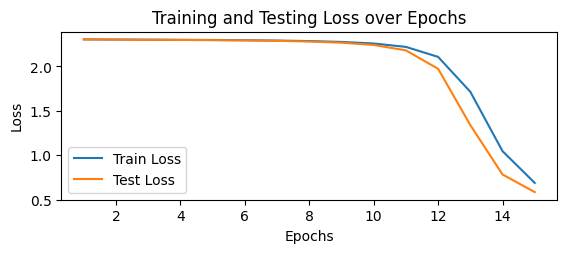

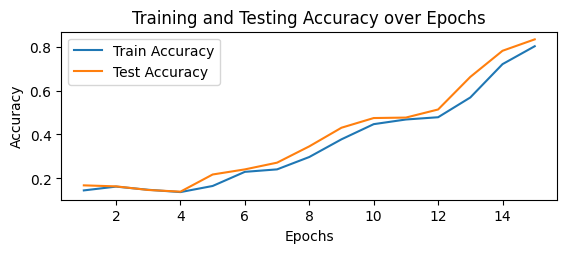

In [25]:
plt.subplot(2,1,1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.show()


Predicted: "7 - seven", Actual: "7 - seven"


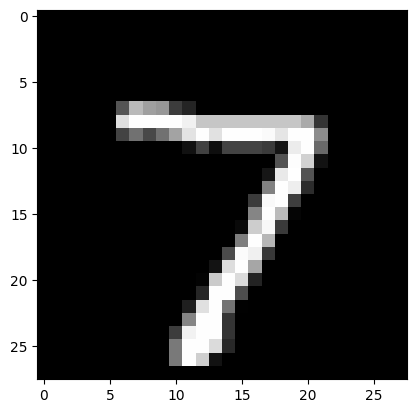

In [26]:
model.eval()
idx = 0
x, y = test_data[idx][0], test_data[idx][1]
plt.imshow(x.permute(1,2,0), cmap = 'gray')
with torch.no_grad():
    x = x.to(device)
    pred = model(x.unsqueeze(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


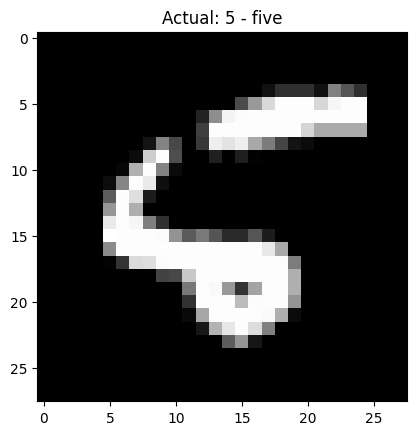

Predicted: "6 - six", Actual: "5 - five"


In [27]:
import matplotlib.pyplot as plt

# Function to display the image and its prediction
def show_prediction(idx):
    model.eval()  # Set the model to evaluation mode
    x, y = test_data[idx][0], test_data[idx][1]  # Get image and label by index
    
    # Display the image
    plt.imshow(x.permute(1, 2, 0), cmap='gray')
    plt.title(f"Actual: {classes[y]}")
    plt.show()

    # Move the image tensor to the correct device
    with torch.no_grad():
        x = x.to(device)  # Move input to the device (e.g., DirectML or CPU)
        pred = model(x.unsqueeze(0))  # Add batch dimension and make a prediction
        
        # Get predicted and actual classes
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Example usage: Show prediction for a specific image (e.g., idx = 10)
idx = 8
show_prediction(idx)